## Background
Since this is my first object detection competition in Kaggle, I am mainly using it for learning. There are great kernel here, mostly using the FastRCNN model And I have learned how to prepare the data and use it with this popular model.I have decided to build a learning kernel, that at least at the beginning will explain the topic and the concepts, the definition and the basics. I will explain every important code line.

## IF you like this kernel, Please upvote

# Introduction

Welcome to the "Global Wheat Detection" competition! In this competition, contestent will detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, contestent will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. contestent will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.

# Acknowledgements

1. PYTORCH TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL [https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html](http://)
2. GREAT KERNEL BY nvnn [https://www.kaggle.com/nvnnghia/fasterrcnn-pseudo-labeling](http://)
3. Pretrained weight [https://www.kaggle.com/mathurinache/fasterrcnn](http://)
4. Fast RCNN : https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4

# Content
### 1.EDA
### 2. Writing a custom dataset for our work
### 3. Define the model
### 4. Finetuning from a pretrained model
### 5. Prediction
### 6. End Note

# 1.EDA

### Install and import necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth
/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/train/ffbf75e5b.jpg
/kaggle/input/global-wheat-detection/train/cce5cb631.jpg
/kaggle/input/global-wheat-detection/train/0679b8bab.jpg
/kaggle/input/global-wheat-detection/train/4c5805bae.jpg
/kaggle/input/global-wheat-detection/train/2474376a6.jpg
/kaggle/input/global-wheat-detection/train/8de789df8.jpg
/kaggle/input/global-wheat-detection/train/9ab4727a2.jpg
/kaggle/input/global-wheat-detection/train/f3c5e09ab.jpg
/kaggle/input/global-wheat-detection/train/e3732d7b7.jpg
/kaggle/input/global-wheat-detection/train/9c05c8d56.jpg
/kaggle/input/global-wheat-detection/train/9d78cb5d0.jpg
/kaggle/input/global-wheat-detection/train/1b547b682.jpg
/kaggle/input/global-wheat-detection/train/7d5af5b74.jpg
/kaggle/input/global-wheat-detection/train/2bfadaa91.jpg
/kaggle/input/global-wheat-detection/t

In [2]:
import cv2
import os
import re
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt

In [3]:
WEIGHTS_FILE = '/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth'

###  Load train and test file

In [4]:
train_df = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
submit = pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")

In [5]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
train_df=train_df.drop(columns=['width','height','source']) #Drop unwanted columns

In [7]:
train_df['image_id'].nunique() # There are total 3373 unique image in training dataset

3373

In [8]:
(train_df['image_id'].value_counts()).max()  # maximum number of boxes in a single image are 116

116

In [9]:
(train_df['image_id'].value_counts()). min() # Minimum number of box in a single image is 1

1

### Splitting the dimension of box in the formate [xmin, ymin, w, h]
#### Latter on we will convert the deminsion of box into [xmin, ymin, xmax, ymax] in 

In [10]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

In [11]:
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x))) ##Lets convert the Box in 
train_df['x'] = train_df['x'].astype(np.float)                                        #in our desired formate    
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [12]:
train_df.head() 

,image_id,bbox,x,y,w,h
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,56.0,36.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,130.0,58.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,74.0,160.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,109.0,107.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,124.0,117.0


### Splitting the data into train and validation set

In [13]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [14]:
trans = transforms.Compose([transforms.ToTensor()])   #Apply transform to image 

# 2.Writing a custom dataset for our work

### 2.1 Writing a custom dataset for train and validation images

In [15]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if(self.train==False):  # For test data
            return image, image_id
        #Else for train and validation data
        records = self.df[self.df['image_id'] == image_id]   
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target,image_id  

In [16]:
train_dir = '/kaggle/input/global-wheat-detection/train'
test_dir = '/kaggle/input/global-wheat-detection/test'

In [17]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, train_dir, trans,True)
valid_dataset = WheatDataset(valid_df, train_dir, trans,True)


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Lets visualize some of the images with bounding box

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

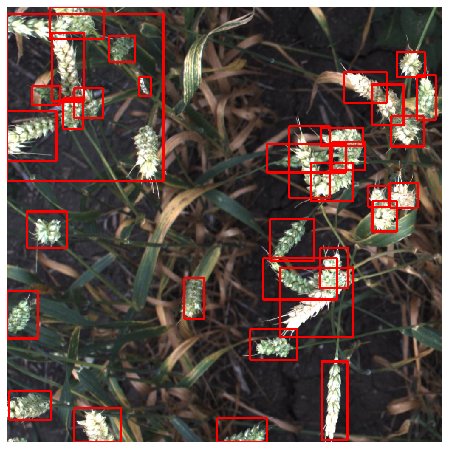

In [19]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# 3.Finetuuning the model

### Defining the model

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.
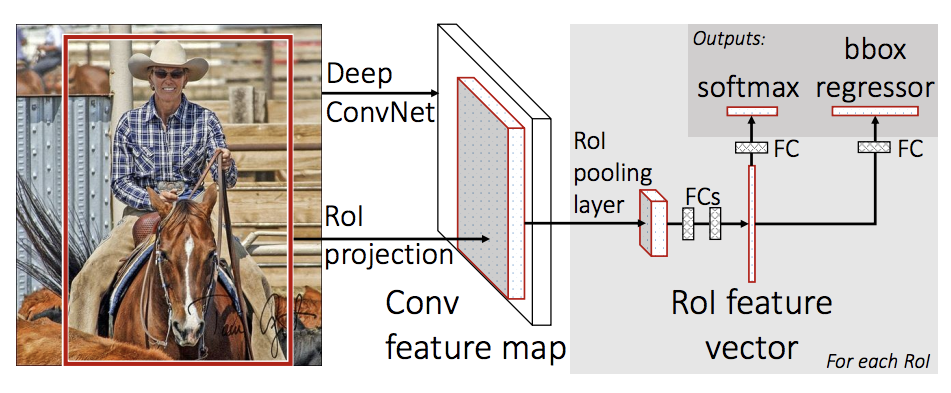


Let’s explain how this architecture works, Faster RCNN is composed from 3 parts

1. Part 1 : Convolution layers : A CNN architecture is formed by a stack of distinct layers that transform the input volume into an output volume (e.g. holding the class scores) through a differentiable function.Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.

2. Part 2 : Region Proposel Network (RPN) : RPN is small neural network sliding on the last feature map of the convolution layers and predict wether there is an object or not and also predict the bounding box of those objects.

3. Part 3 : Classes and Bounding Boxes prediction : Now we use another Fully connected neural networks that takes as an inpt the regions proposed by the RPN and predict object class ( classification) and Bounding boxes (Regression).

*There are two common situations where one might want to modify one of the available models in torchvision modelzoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one . In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small, so we will be following approach number first.*

In [20]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has booth classes, your labels tensor should look like [1,2].

In our case number of classes are 2, class 0 for background and class 1 for wheat.

In [21]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))  ##Load pre trained weights
#model.eval()

#x = model.to(device)

<All keys matched successfully>

### Lets train our model

In [22]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#lr_scheduler = None

num_epochs = 5

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.7195800542831421
Iteration #100 loss: 0.5636919736862183
Iteration #150 loss: 0.5164844989776611
Epoch #0 loss: 0.6035307493279962
Iteration #200 loss: 0.6471360921859741
Iteration #250 loss: 0.5148703455924988
Iteration #300 loss: 0.5007541179656982
Epoch #1 loss: 0.6009974697056939
Iteration #350 loss: 0.5564839839935303
Iteration #400 loss: 0.6559533476829529
Iteration #450 loss: 0.41047757863998413
Iteration #500 loss: 0.5574262142181396
Epoch #2 loss: 0.5914770755697699
Iteration #550 loss: 0.6127468943595886
Iteration #600 loss: 0.6138687133789062
Iteration #650 loss: 0.6188045740127563
Epoch #3 loss: 0.5793729433242012
Iteration #700 loss: 0.7031135559082031
Iteration #750 loss: 0.6821487545967102
Iteration #800 loss: 0.47700265049934387
Iteration #850 loss: 0.4653645157814026
Epoch #4 loss: 0.5745457828044891


# 4. Prediction

### Lets load the test data

In [23]:
test_dataset = WheatDataset(submit,test_dir, trans,False)

In [24]:
test_data_loader = DataLoader( test_dataset, batch_size=8, shuffle=False)  ##Test dataloader

### Set the threshold value for predicting bounding box.

In [25]:
detection_threshold = 0.45

In [26]:
def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [27]:
## Lets make the prediction
results=[]
model.eval()

for images, image_ids in test_data_loader:    

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
        scores = scores[scores >= detection_threshold]                    #slelect only those boxes whose score is greater
                                                                          # than threshold value
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]         #Convert the box formate to [Xmin,Ymin,W,H]
        
        
            
        result = {                                     #Store the image id and boxes and scores in result dict.
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)              #Append the result dict to Results list

In [28]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9969 558 530 125 183 0.9924 615 912 77 106 0...
1,51f1be19e,0.9978 603 77 164 180 0.9935 498 454 213 114 0...
2,f5a1f0358,0.9964 134 747 163 123 0.9944 541 264 112 113 ...
3,796707dd7,0.9926 940 64 83 105 0.9919 705 817 116 103 0....
4,51b3e36ab,0.9981 683 606 336 134 0.9980 831 443 189 148 ...


In [29]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

### Lets plot some of our prediction

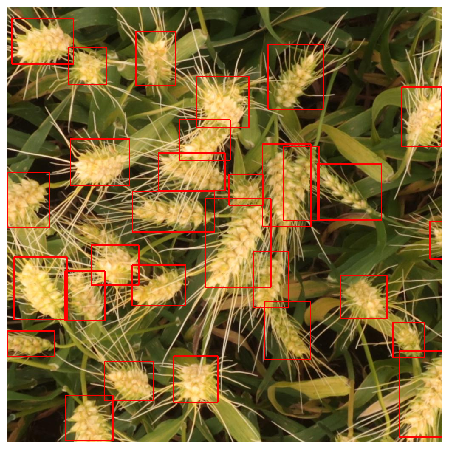

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

## Submission

In [31]:
test_df.to_csv('submission.csv', index=False)

## If you like this kernel, Please upvote it 